## Portfolio Exercise Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their candidates.   The data for this exercise consists of about 120,000 data points split in 2:1 ratio among training and test files. Each data point includes one column indicating whether or not an individual was sent a promotion for a specific product, and one column indicating whether or not that individual eventually purchased that product. Each individual also had seven additional features associated with them.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user.  Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

Ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group.

* **Net Incremental Revenue (NIR)**

The total number of purchasers that received the promotion times 10 minus the number of promotions given times 0.15 minus the number of purchasers who were not given the promotion times 10.

For a full description of what starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the **promotion_strategy** function to pass to the **test_results** function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers.  

|   | Actual      |    |    | 
|---|-------------|----|----|
| **Predicted**   | Yes| No |  
| Yes             | **I**   | **II**|  
| No              | **III** | **IV**|  

The metrics are only being compared for the individual's we predict should obtain the promotion - that is quadrants I and II here.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equal participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 


Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final test_results function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
import scipy.stats as stats
from statsmodels.stats import proportion as proptests

In [3]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

## I. Statistical significance testing of the AB test results

In [4]:
n_obs = train_data.shape[0]
print(n_obs)

84534


In [5]:
train_data["Promotion"].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [6]:
dict_promotion = {"No":0,"Yes":1}
train_data["is_promotion"]= train_data["Promotion"].map(dict_promotion)

In [7]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,is_promotion
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [8]:
train_data.groupby("Promotion").count()["ID"]

Promotion
No     42170
Yes    42364
Name: ID, dtype: int64

In [9]:
df_is_promotion = train_data.iloc[np.where(train_data.is_promotion==1)]
print(df_is_promotion.shape)

(42364, 11)


In [10]:
df_no_promotion = train_data.iloc[np.where(train_data.is_promotion==0)]
print(df_is_promotion.shape)

(42364, 11)


In [13]:
n_e = train_data["is_promotion"].sum(axis=0)
print(n_e)

n_c = n_obs - n_e
print(n_c)

42364
42170


In [14]:
# Check p-value for invarient metrics (i.e. number of person per group)
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_c + 0.5) - p * n_obs) / sd
print(z)

p_val = 2*(1-stats.norm.cdf(abs(z))) # Do not reject the null hypothesis
print(p_val)

-0.6638066506192843
0.5068140685419045


In [15]:
train_data.groupby("Promotion").sum()["purchase"]

Promotion
No     319
Yes    721
Name: purchase, dtype: int64

In [16]:
purchase_e = df_is_promotion["purchase"].sum(axis=0)
print(purchase_e)

purchase_c = df_no_promotion["purchase"].sum(axis=0)
print(purchase_c)

721
319


In [17]:
# Check p-value for evaluation metrics

p_pop = train_data["purchase"].mean()
print(p_pop) # 0.012

p_c = purchase_c/n_c
print(p_c*100)
p_e = purchase_e/n_e
print(p_e*100)

se_p = np.sqrt(p_pop * (1-p_pop) * (1/n_c + 1/n_e))

z = (p_e - p_c) / se_p
print(z)
print(1-stats.norm.cdf(abs(z))) # less than 0.01 hence reject the null with high confidence, hence p_c is significantly greater than p_e

# even when sampling at random, the proportion to buy is increased significantly
irr = (p_e - p_c)
print("The project irr is of {}".format(irr))

# however, the promotion had an important costs
nir = 10 * purchase_e - 0.15 * n_e - 10 * n_c
print(nir)

0.012302742091939338
0.7564619397676073
1.7019167217448776
12.468449461599388
0.0
The project irr is of 0.009454547819772702
-420844.6


# II. Building an optimization strategy with a supervised learning algorithm

## Deep dive into the data

In [58]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            84534 non-null  int64  
 1   Promotion     84534 non-null  object 
 2   purchase      84534 non-null  int64  
 3   V1            84534 non-null  int64  
 4   V2            84534 non-null  float64
 5   V3            84534 non-null  float64
 6   V4            84534 non-null  int64  
 7   V5            84534 non-null  int64  
 8   V6            84534 non-null  int64  
 9   V7            84534 non-null  int64  
 10  is_promotion  84534 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 7.1+ MB


In [18]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,is_promotion
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694,0.501147
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517,0.500002
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000,0.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000,0.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000,1.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000,1.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000,1.000000


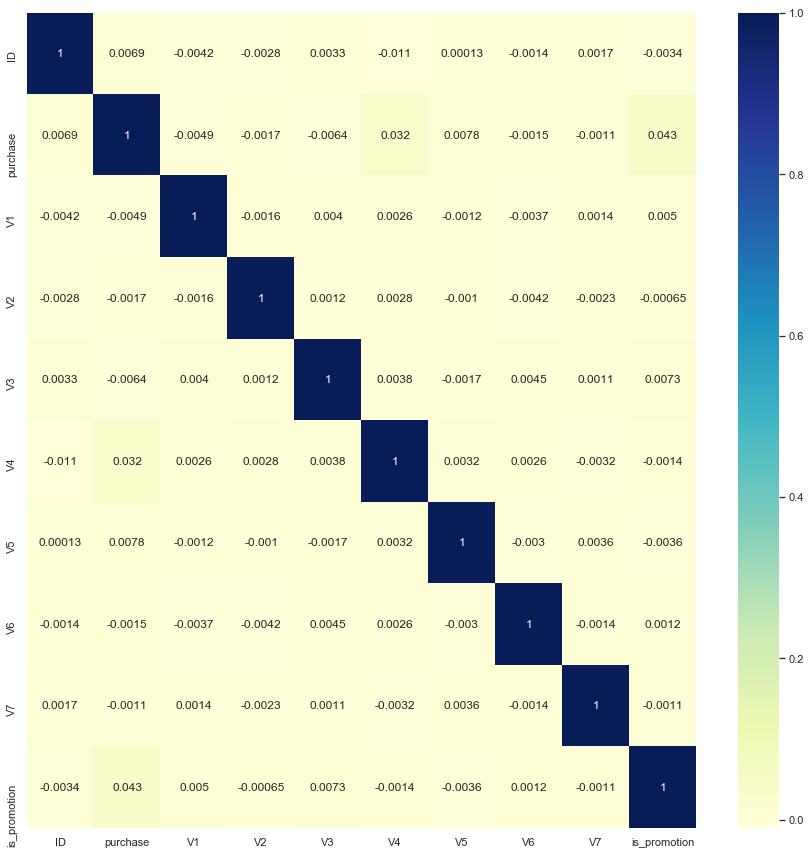

In [25]:
sb.set(rc={'figure.figsize':(15,15)})
sb.heatmap(train_data.corr(),annot=True, cmap="YlGnBu")

In [26]:
train_data["is_purchased"]=train_data["purchase"].apply(lambda x: "True" if x==1 else "False")
#train_data.loc[train_data.purchase==1].head()

In [27]:
columns_to_consider = set(train_data.columns.values)-set(["ID","Promotion","purchase"])
print(columns_to_consider)

{'V1', 'is_purchased', 'V7', 'V3', 'V5', 'V4', 'V2', 'V6', 'is_promotion'}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d9faeb8>,
      dtype=object)

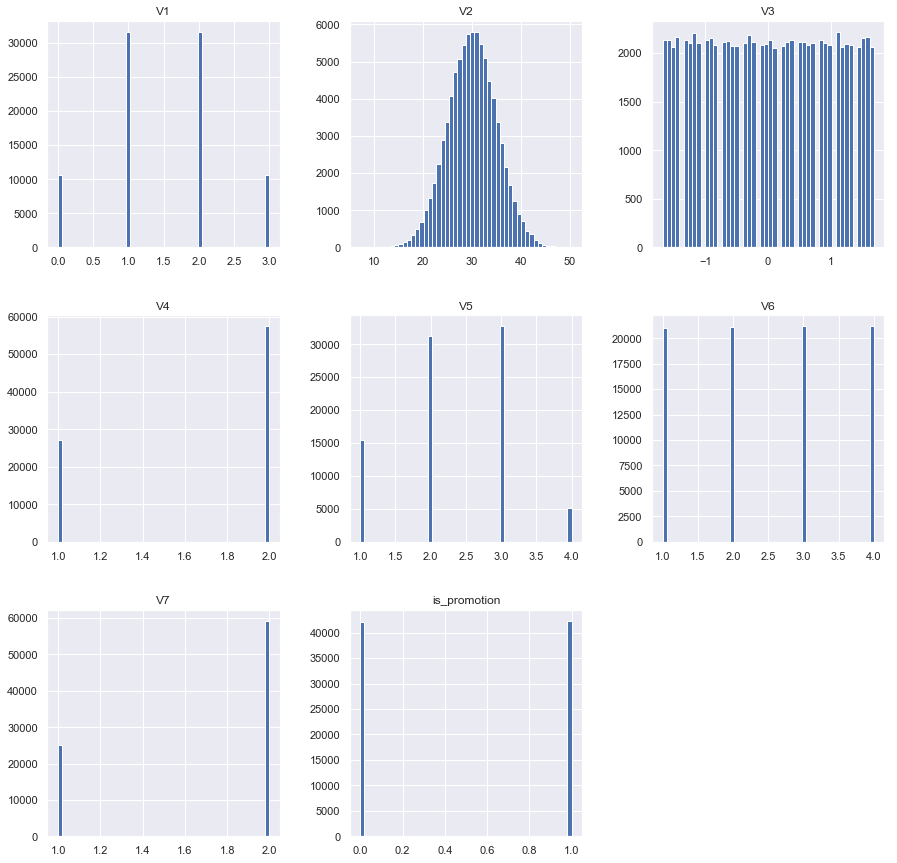

In [28]:
train_data[columns_to_consider].hist(bins=50, figsize=(15,15))
#train_data[columns_to_consider].plot(kind="density", figsize=(15,15),subplots=True)

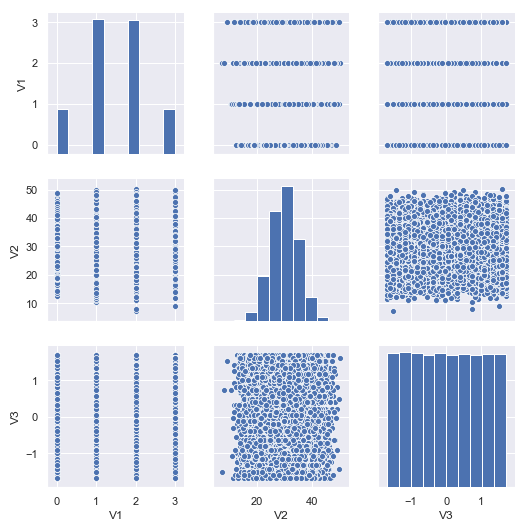

In [29]:
numerical =["V1","V2","V3"]
sb.pairplot(train_data[numerical]);

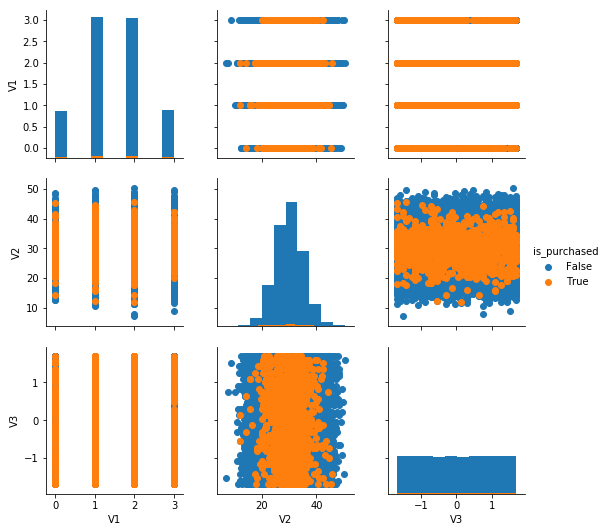

In [104]:
numerical =["V1","V2","V3","is_purchased"]
g = sb.PairGrid(train_data[numerical], hue="is_purchased")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

#https://seaborn.pydata.org/examples/scatterplot_matrix.html
#sb.pairplot(train_data, kind="bar",hue="is_purchased")

## Machine Learning scoring algorithm : prediction of probability to purchase hence classification problems

In [31]:
train_data = pd.read_csv('data/training.csv').copy()
train_data["is_purchased"]=train_data["purchase"].apply(lambda x: "True" if x==1 else "False")
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,is_purchased
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,False
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,False
2,4,No,0,2,30.431659,0.133583,1,1,4,2,False
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,False
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,False


In [32]:
num_features =["V1","V2","V3","V4","V5","V6","V7"]
X = train_data[num_features]
y = train_data.pop("purchase")

In [33]:
y.value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

### T-SNE representation (very long to run)

In [41]:
# TSNE representation of the data :

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Reduce the number of lines so that T-SNE can be computed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42,shuffle=True)

scaler = StandardScaler()
scaler.fit(X)
X_corr = scaler.transform(X_train)
print(X_corr.shape)

(8453, 7)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


tsne = TSNE(random_state=17)
tsne_repr = tsne.fit_transform(X_corr)

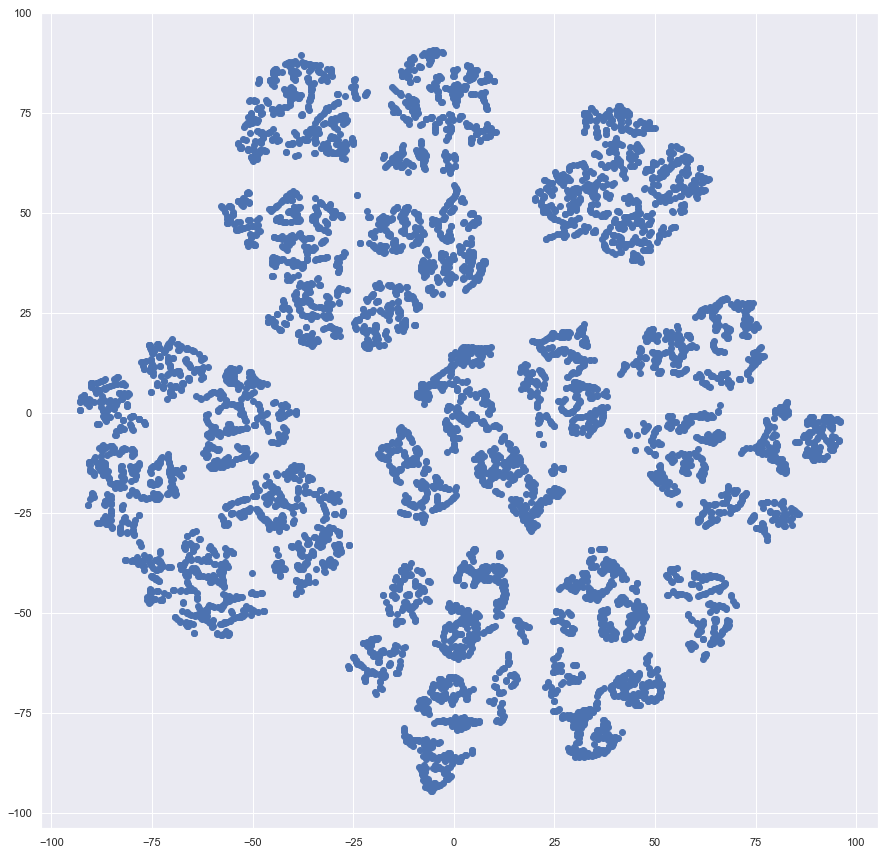

In [43]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1]);

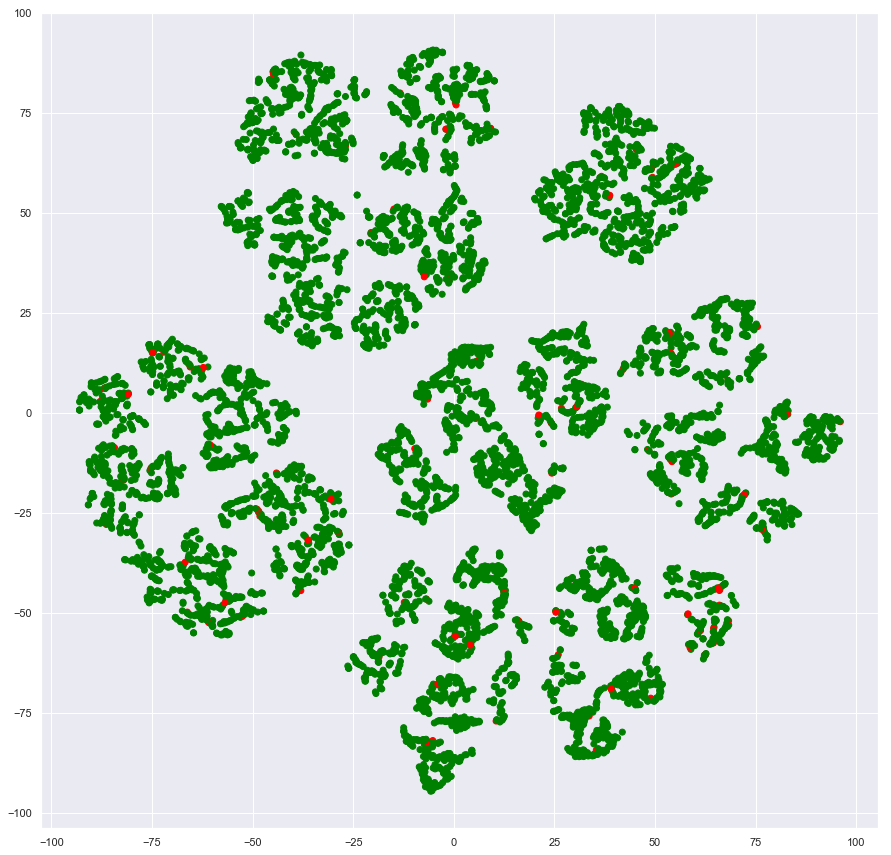

In [46]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], 
            c=y_train.map({0: 'green', 1: 'red'}));

# Split between train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve,auc,fbeta_score, accuracy_score
from sklearn import ensemble
from sklearn.model_selection import StratifiedKFold,train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True,
                                                        random_state=0)

In [51]:
y_train.value_counts()[1]/(y_train.value_counts()[0]+y_train.value_counts()[1]) # Higly unbalanced data set

0.012480222396380145

In [96]:
y_test.value_counts()[1]/(y_test.value_counts()[0]+y_test.value_counts()[1]) # Higly unbalanced data set

0.011592831371621221

In [52]:
# Feature Engineering: no-non null values, only standardization is needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_corr = scaler.transform(X_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [117]:
# Implement GBM with early stopping
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-early-stopping-py

learner1 = ensemble.GradientBoostingClassifier(n_estimators=500,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0)
learner3 = ensemble.GradientBoostingClassifier()

learner2 = ensemble.RandomForestClassifier(n_estimators=248,max_depth=5,random_state=42,bootstrap=True,n_jobs=-1, class_weight="balanced")

In [118]:
learner = learner2
learner.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=248, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)>

In [119]:
def classification_score(X,y,learner):
    
    # Evaluation on the set
    y_pred = learner.predict(X)
    print("Unique value in the predictions ".format(np.unique(y_pred)))
    
    accuracy = accuracy_score(y,y_pred)
    print("acccuracy is of {}".format(accuracy))

    recall = recall_score(y,y_pred)
    print("recall is of {}".format(recall))

    precision = recall_score(y,y_pred)
    print("Precision is of {}".format(recall))

    f1 = fbeta_score(y,y_pred,average='binary',beta=0.5)
    print("f1 is of {}".format(f1))

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y,y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("roc auc is of {}".format(roc_auc))

In [120]:
# Results on the training sets
learner.fit(X_train_corr,y_train)
classification_score(X_train_corr,y_train,learner)

Unique value in the predictions 
acccuracy is of 0.583686988924542
recall is of 0.6706161137440758
Precision is of 0.6706161137440758
f1 is of 0.02469200432764457
roc auc is of 0.6266022485076338


In [121]:
# Results on the test set

X_test_corr = scaler.transform(X_test)
classification_score(X_test_corr,y_test,learner)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Unique value in the predictions 
acccuracy is of 0.5757378600579641
recall is of 0.6173469387755102
Precision is of 0.6173469387755102
f1 is of 0.020810401761144744
roc auc is of 0.5962983871066229


## Fine tune the model

In [98]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [157]:
param_distribs_RF = {
        #'learning_rate':[1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': randint(low=1, high=500),
        'max_depth': randint(low=1, high=8),
    }

#https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae
#https://www.kaggle.com/zksharp48/fraud-detection-gradient-boosting-oversampling - for SMOTE applications
param_distribs_GBM = {
        'learning_rate':[1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators':randint(low=1, high=200),
        'max_depth':randint(low=1, high=10)
    }

In [158]:
learner1 = ensemble.RandomForestClassifier(random_state=42,class_weight="balanced")
learner2 = ensemble.GradientBoostingClassifier()

learner = learner2 #learner1
param_distribs = param_distribs_GBM #param_distribs_RF

In [160]:
import time
start = time.time()
skfolds = StratifiedKFold(n_splits=3, random_state=42)

rnd_search = RandomizedSearchCV(learner, param_distributions=param_distribs,
                                n_iter=10, cv=skfolds, scoring='f1')
rnd_search.fit(X_train_corr,y_train)
end = time.time()-start
print(end)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-sco

297.1516680717468


In [161]:
final_model = rnd_search.best_estimator_
final_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=89,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

In [162]:
X_test_corr = scaler.transform(X_test)
classification_score(X_test_corr,y_test,final_model)

Unique value in the predictions 
acccuracy is of 0.9632105045247531
recall is of 0.030612244897959183
Precision is of 0.030612244897959183
f1 is of 0.015400410677618069
roc auc is of 0.5023805045924779


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [153]:
import pickle
# model_file_path ="rf_best_model"
model_file_path = "gbm_best_model"
pickle.dump(final_model, open(model_file_path, 'wb'))

In [155]:
final_model = pickle.load(open("rf_best_model", 'rb'))
final_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=248, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)>

In [129]:
results = final_model.predict(X_test_corr)
results[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1])

In [136]:
df_results=pd.DataFrame({"predictions":results})
df_results["predictions_map"]=df_results["predictions"].map({1:"Yes",0:"No"})
df_results.head()

,predictions,predictions_map
0,1,Yes
1,0,No
2,1,Yes
3,0,No
4,1,Yes


In [138]:
list_results = np.array(df_results["predictions_map"])
list_results

array(['Yes', 'No', 'Yes', ..., 'Yes', 'Yes', 'No'], dtype=object)

## Promotion strategy

In [142]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X_test_corr = scaler.transform(df)
    results = final_model.predict(X_test_corr)
    df_results=pd.DataFrame({"predictions":results})
    df_results["predictions_map"]=df_results["predictions"].map({1:"Yes",0:"No"})
    promotion = np.array(df_results["predictions_map"])
    
    return promotion

In [144]:
test_data = pd.read_csv('data/Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [146]:
df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
promos = promotion_strategy(df)
promos[0:10]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


array(['No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes'],
      dtype=object)

In [148]:
score_df = test_data.iloc[np.where(promos == 'Yes')]    
irr, nir = score(score_df)
print("Nice job!  See how well your strategy worked on our test data below!")
print()
print('Your irr with this strategy is {:0.2f}.'.format(irr))
print()
print('Your nir with this strategy is {:0.2f}.'.format(nir))

print("Approximately, the highest scores obtained at Udacity were: irr of {} and an nir of {}.\n\n How did you do?".format(0.1, 300))

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.02.

Your nir with this strategy is 367.10.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


# This will test your results, and provide you back some information 
# on your how well your promotion_strategy will work in practice

from test_results import test_results, score
test_results(promotion_strategy)